In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd

In [2]:
import mplhep as hep
plt.style.use(hep.style.CMS)

In [3]:
store_gamma = pd.HDFStore("output_PU_clusters_check_gamma_v7.h5")
df_gamma = store_gamma['df']
store_gamma.close()

In [4]:
store_ele = pd.HDFStore("output_PU_clusters_check_electron_v7.h5")
df_ele = store_ele['df']
store_ele.close()

In [5]:
print("N events ele", len(df_ele))
print("N events gamma", len(df_gamma))

N events ele 2851053
N events gamma 2256072


# Resolution study

Let's study the best threshold for resolution

In [21]:
df = df_ele

In [22]:
def bin_analysis(group):
    ratio_left = group["EoEtrue"].quantile(0.16)
    ratio_right = group["EoEtrue"].quantile(0.84)
    ratio_mean = group[(group.EoEtrue >= ratio_left) & (group.EoEtrue <= ratio_right) ].EoEtrue.mean()
    count = group["EoEtrue"].count()
    return pd.Series(  
        { 
             "quantile_down": ratio_left,
             "quantile_up": ratio_right,
             "EoEtrue_68scale": ratio_mean,
             "EoEtrue_68width": (ratio_right-ratio_left)/2, 
             #"EoEtrue_68width": abs(ratio_right- ratio_left), 
             "EoEtrue_scale":  group.EoEtrue.mean(),
             "EoEtrue_rms":  group.EoEtrue.std(),
             "rel_err" : 1/np.sqrt(count)
        })


In [23]:
etas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.35, 1.44, 1.57, 1.75, 2.0 ,2.2,2.4,3.0]
ets =   [ 0,2,3,4,6,10,15,20,30,40,50,60,70,80,90,100]

In [24]:
seed = df[(df.is_seed==1)][['wi','en','eta','et', 'simfrac_sig']]
seed.columns = ['wi','seed_en','seed_eta','seed_et','seed_simfrac_sig']

dfa = df.join(seed.set_index("wi"), on='wi')

In [32]:
thres = [0.01, 0.03,0.05,0.07,0.1,0.2,0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,1]
res= []
res_all = []

# on top di: 
# -passa simfraction
# -seed at least 1% di simFrac 
# -cluster in window
dfb = dfa[(dfa.pass_simfrac_thr==1) & (dfa.seed_simfrac_sig > 0.01 ) & (dfa.in_window==1)]

for thr in thres:
    #print("DNN threshold: ", thr)
    g = dfb[(dfb.simen_sig_frac >  thr) | (dfb.is_seed==1) ].groupby("wi", sort=False).agg(
                        {
                         "en": 'sum' ,
                         "calo_genen": "first", 
                         "calo_simen_good": "first", 
#                          "calo_simet": "first",
#                          "calo_eta": "first",
                         "seed_et": "first",
                         "seed_eta": "first"
                            })
    g["EoEtrue"] = g["en"] / g["calo_simen_good"]
    g["thr"]= thr
    g["et_bin"] = pd.cut(g["seed_et"], ets, labels=list(range(len(ets)-1)))
    g["eta_bin"] = pd.cut(g["seed_eta"], etas, labels=list(range(len(etas)-1)))

    scanres = g.groupby(["et_bin","eta_bin"]).apply(bin_analysis)                   
    scanres["thr"] = thr
    res.append(scanres)
    res_all.append(g)

res = pd.concat(res)
res_all = pd.concat(res_all)
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)

In [27]:
import os
outputdir = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/validation_sim_truth/signalfraction_ele"
os.makedirs(outputdir, exist_ok=True)

## By Et and eta bin

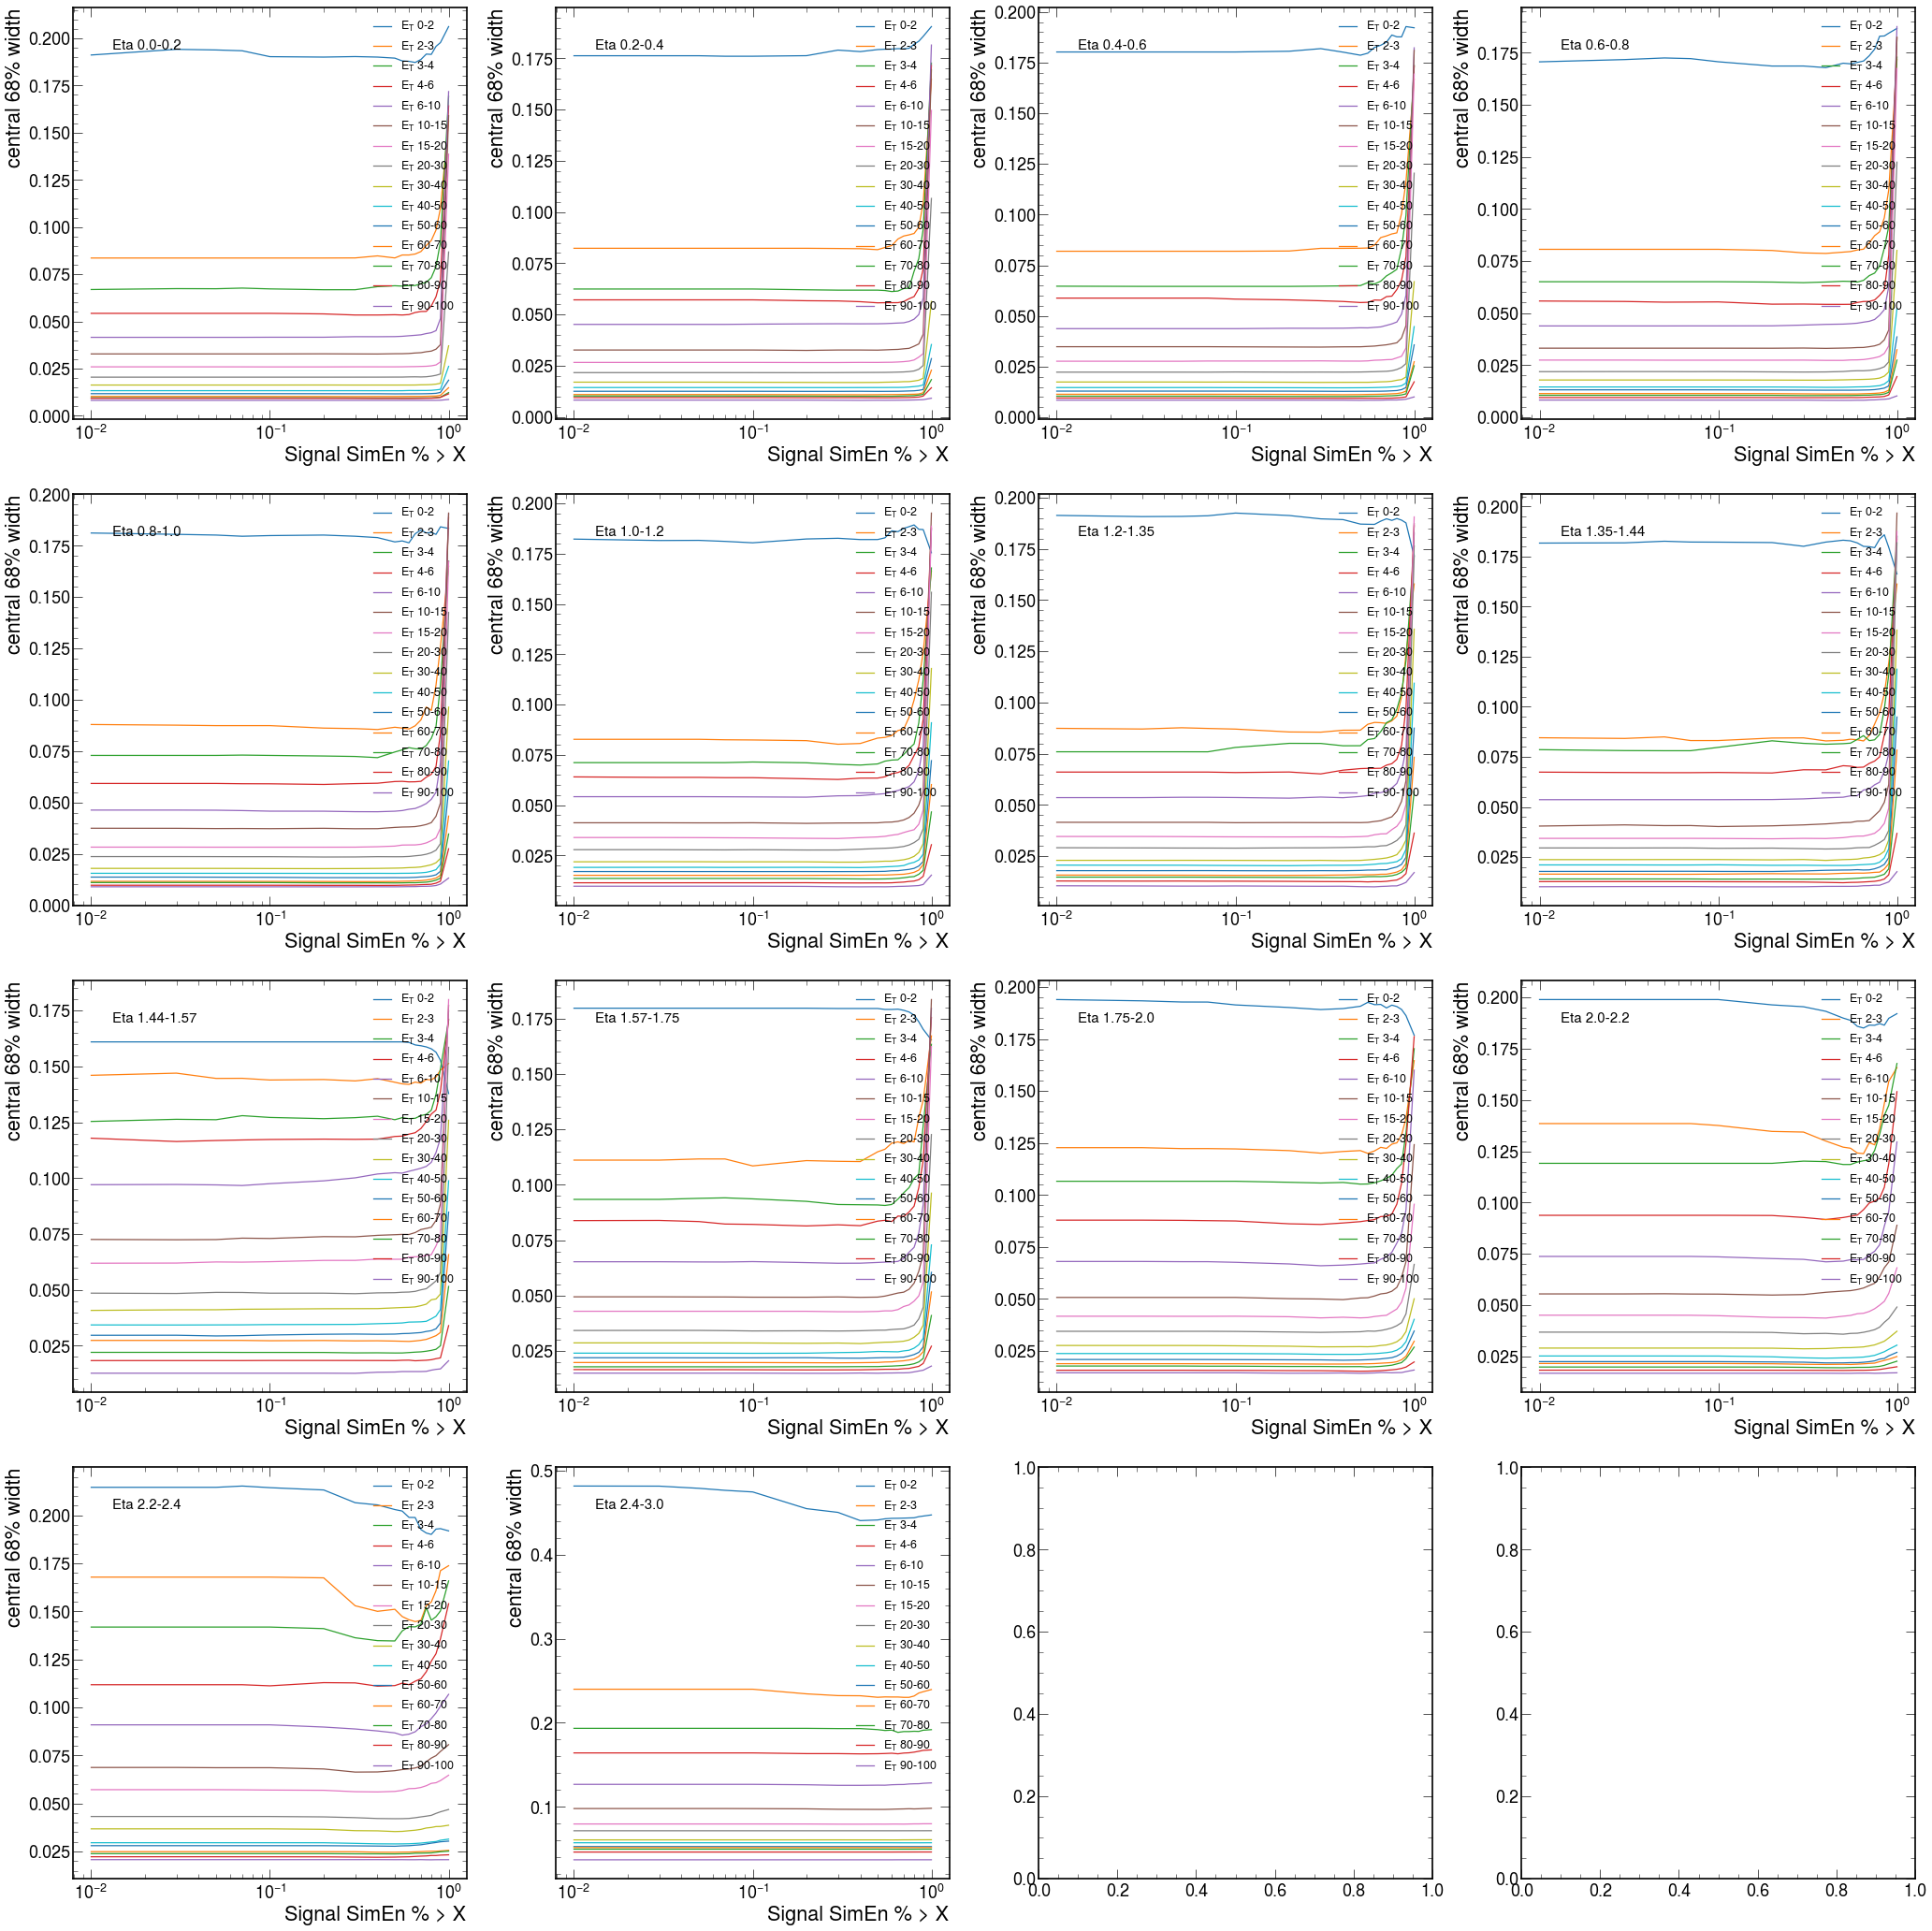

In [38]:
f, axs = plt.subplots(4,4, figsize=(35,35), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(len(ets)-1):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.1,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper right')
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("Signal SimEn % > X")
#     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")
    
f.tight_layout()    
f.savefig(outputdir + "/width_by_PU_thre.png")

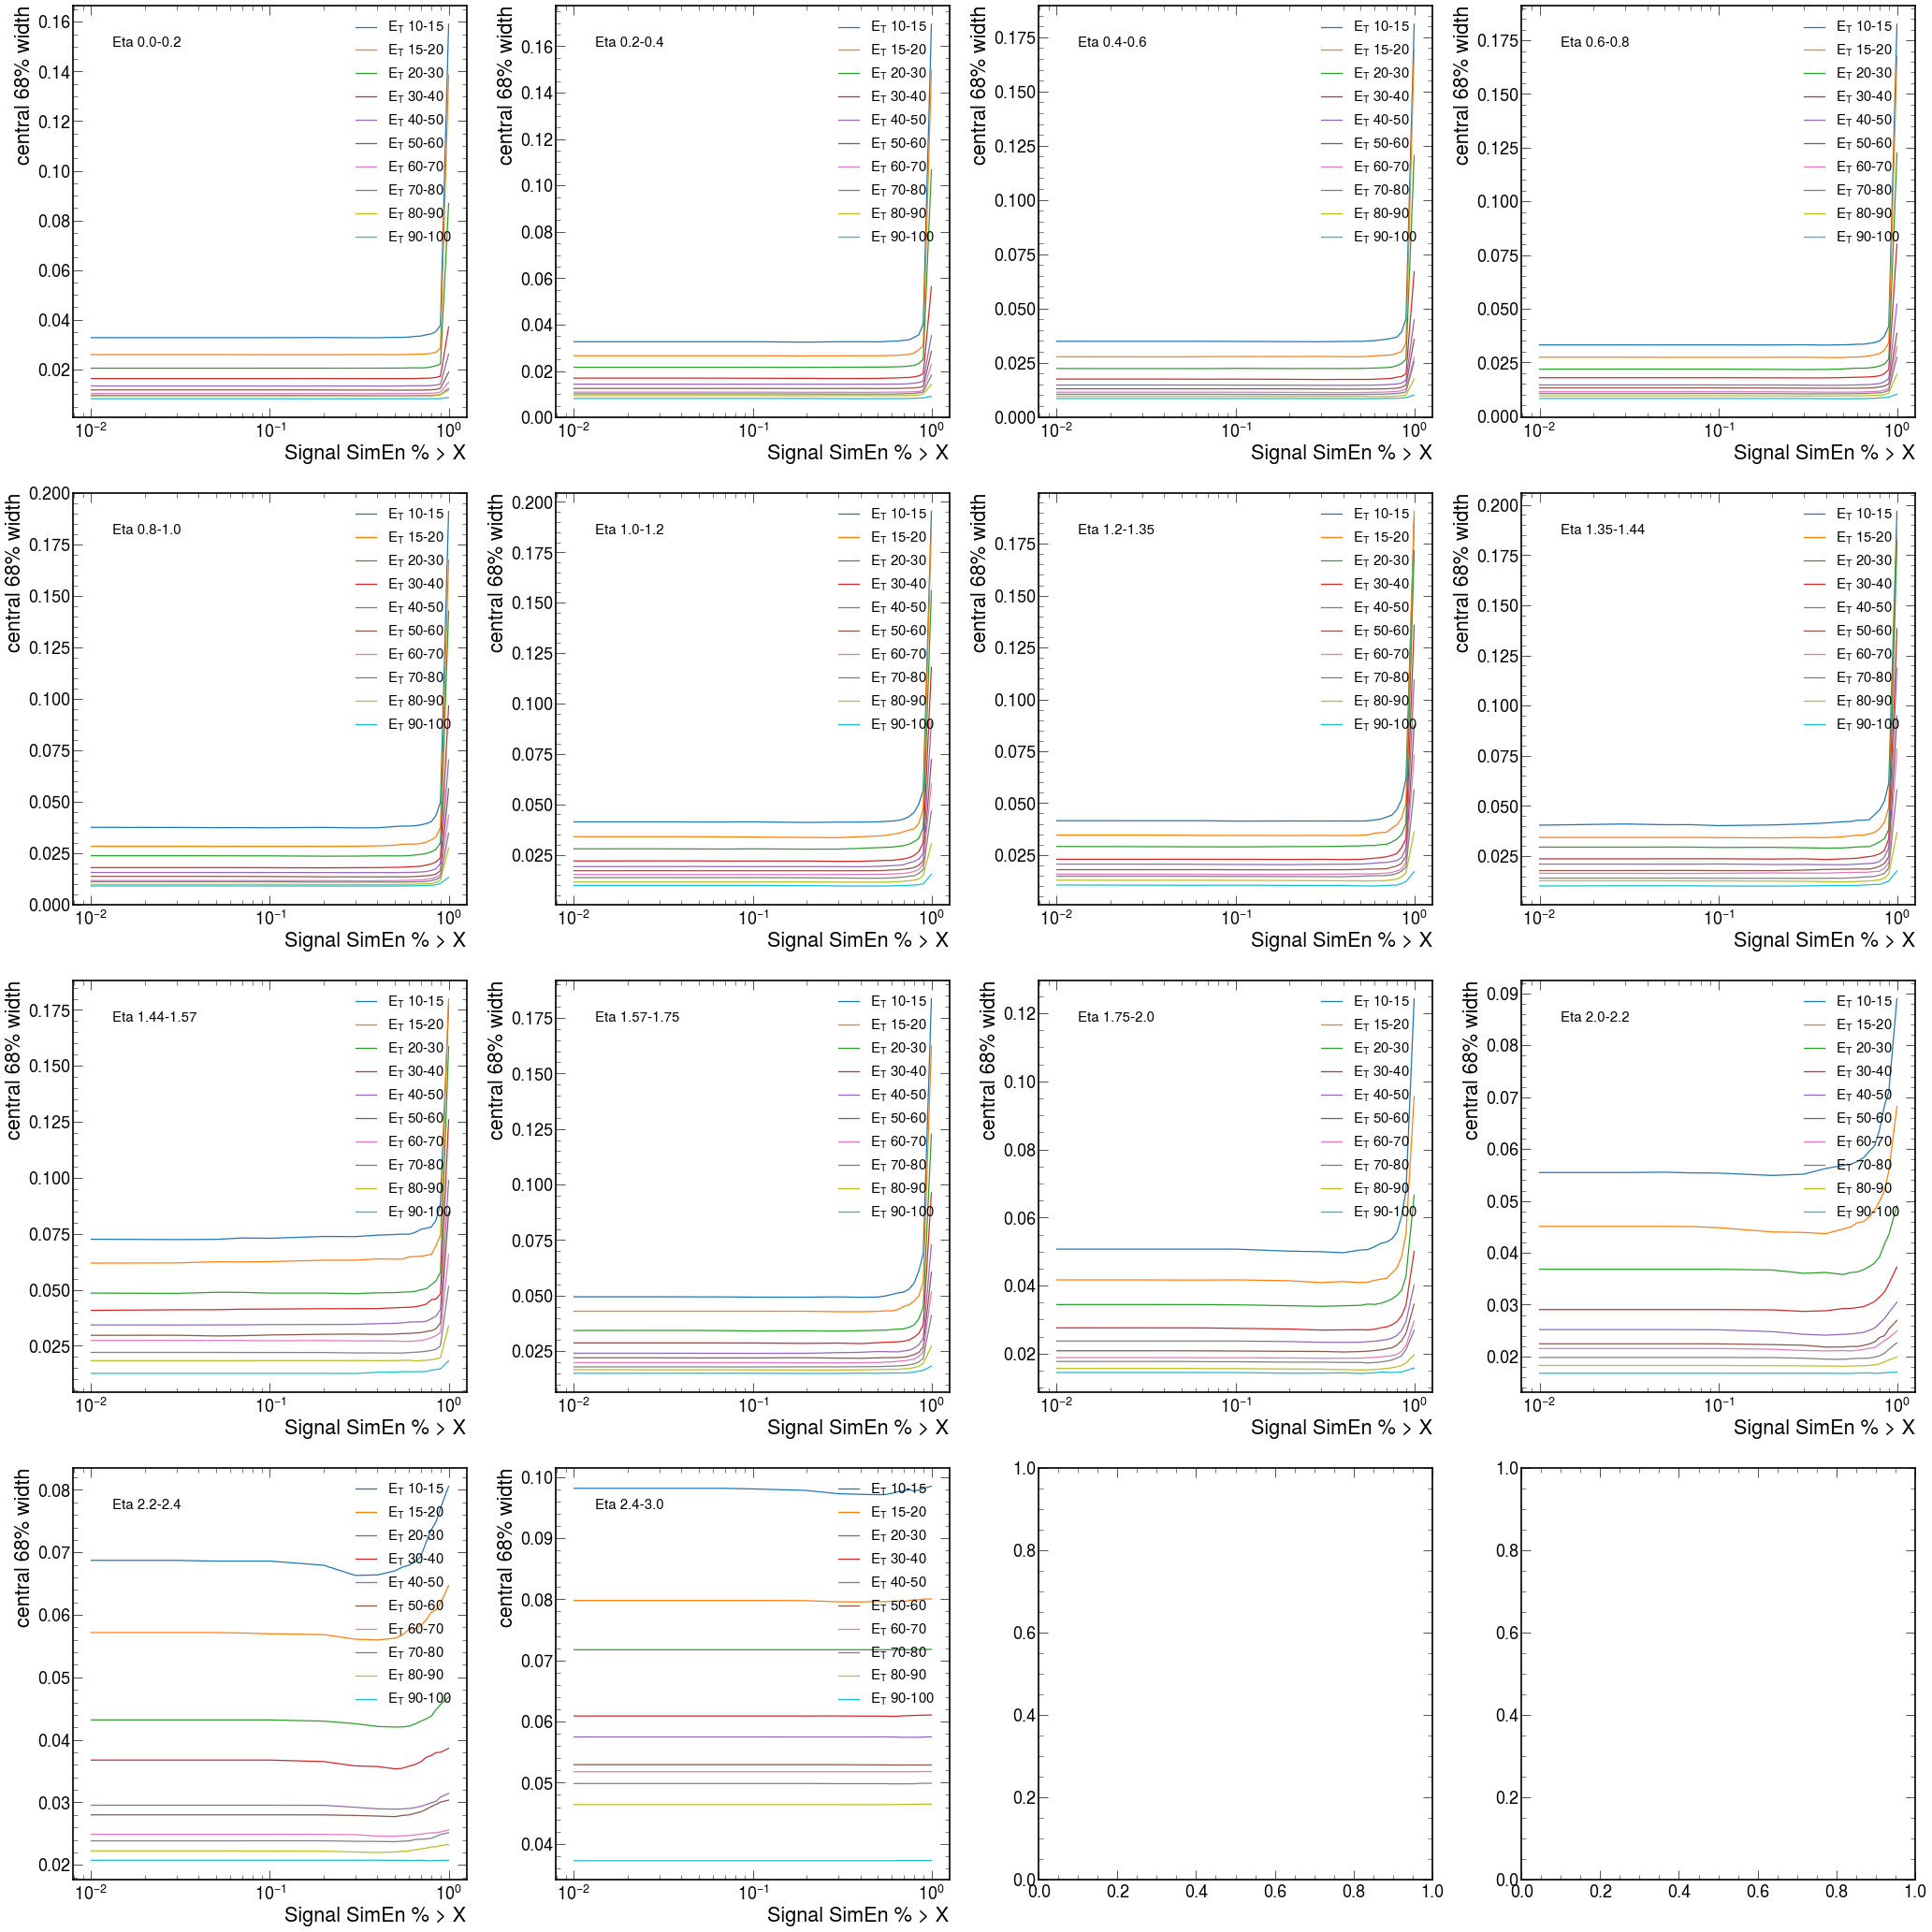

In [39]:
f, axs = plt.subplots(4,4, figsize=(35,35), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(5,len(ets)-1):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.1,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="x-small", loc='upper right')
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("Signal SimEn % > X")
#     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

f.tight_layout()
f.savefig(outputdir + "/width_by_PU_thre_highEn.png")

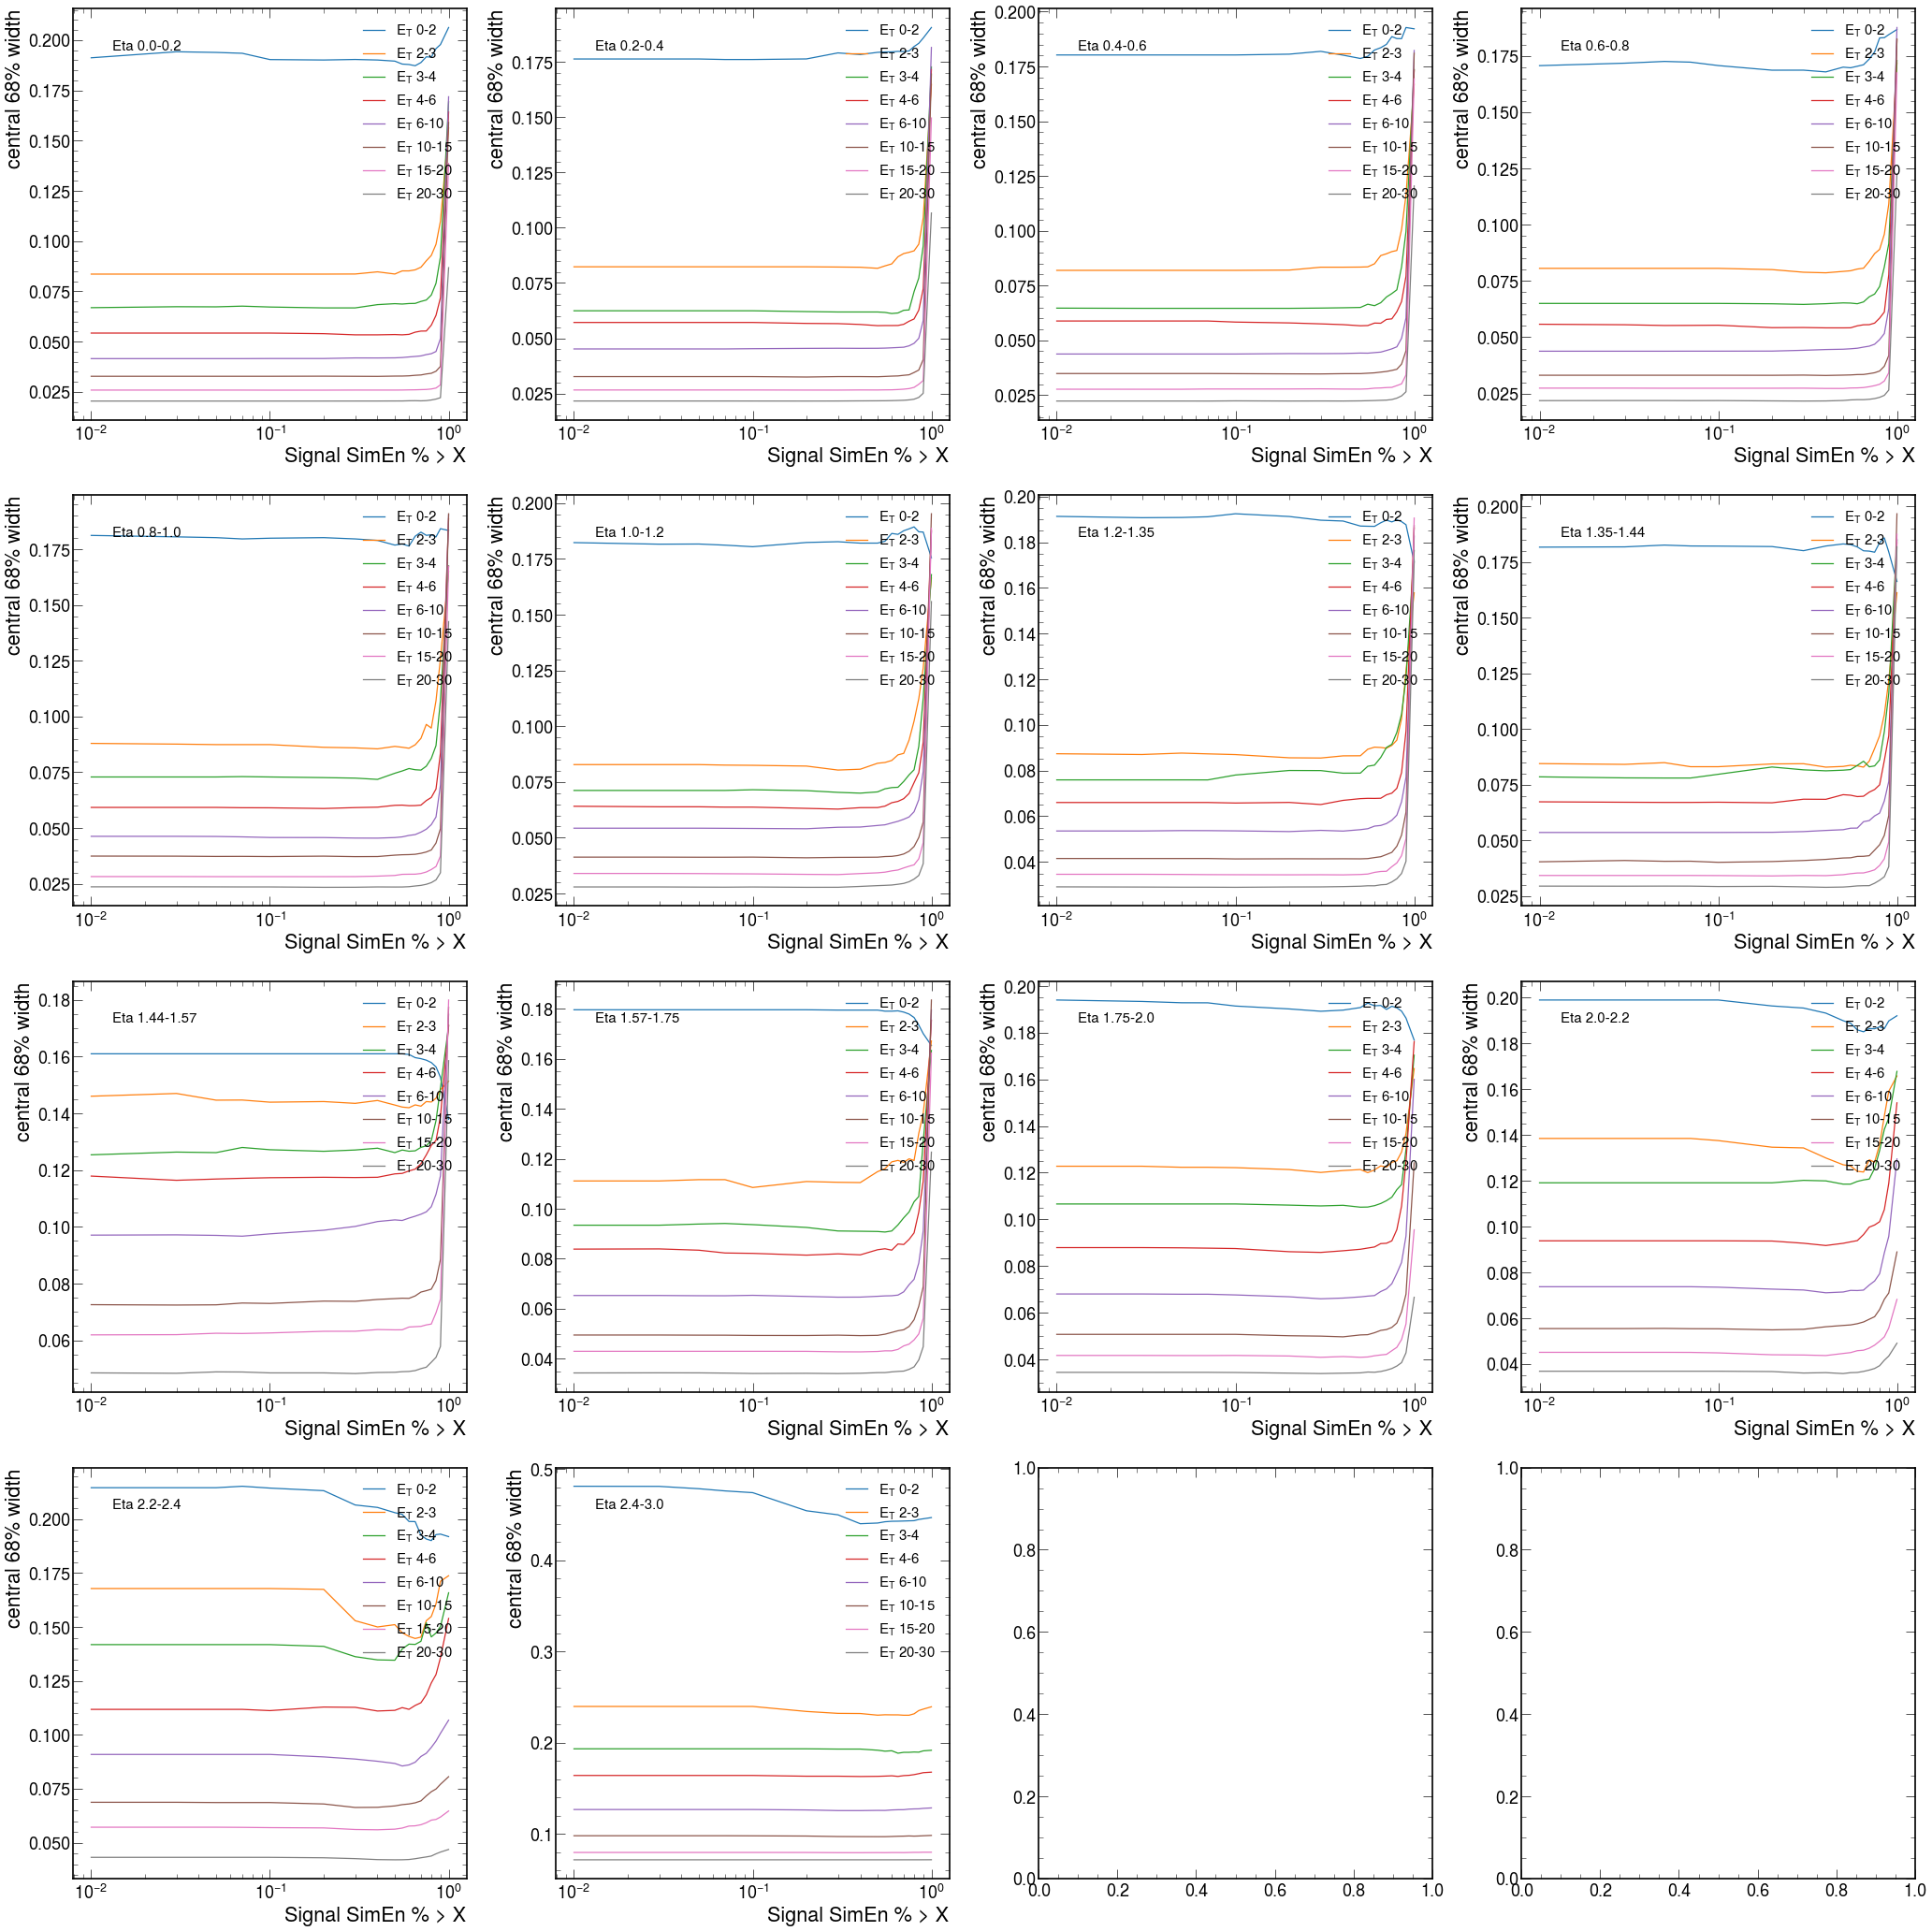

In [40]:
f, axs = plt.subplots(4,4, figsize=(35,35), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(0,8):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.1,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="x-small", loc='upper right')
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("Signal SimEn % > X")
#     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

f.tight_layout()
f.savefig(outputdir + "/width_by_PU_thre_lowEn.png")

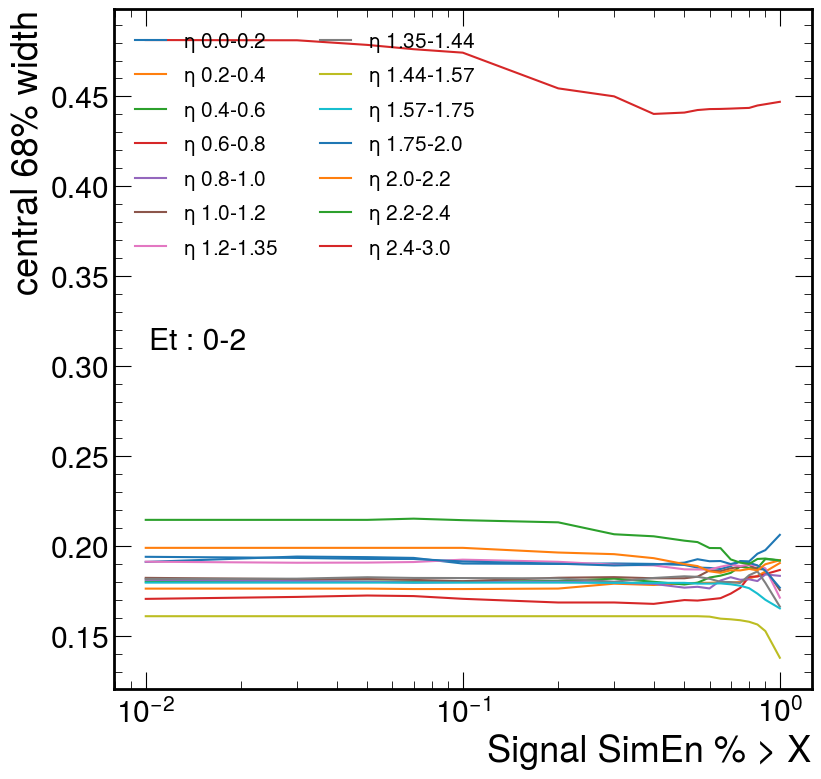

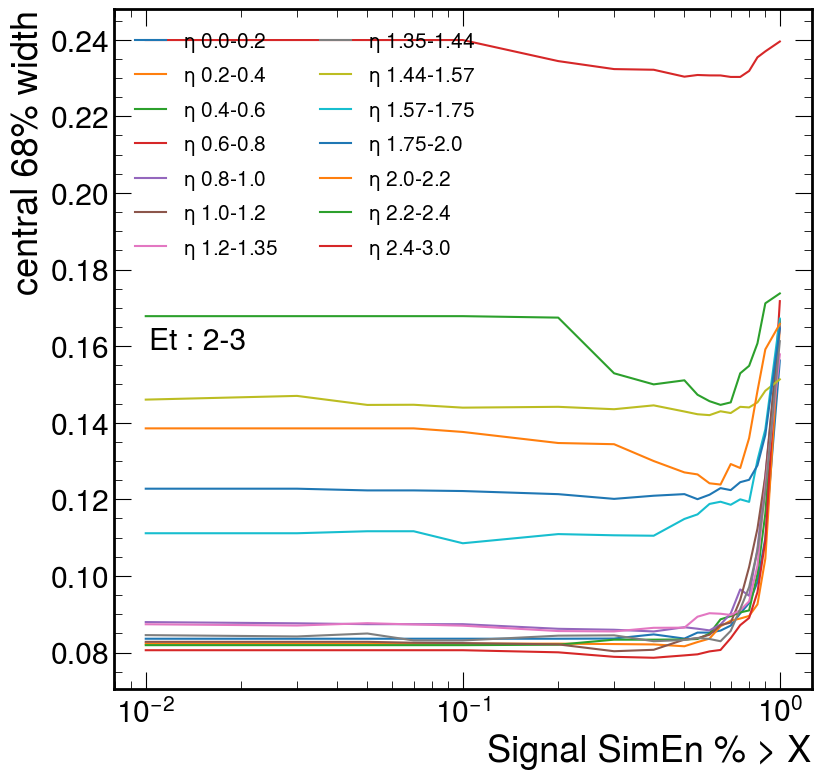

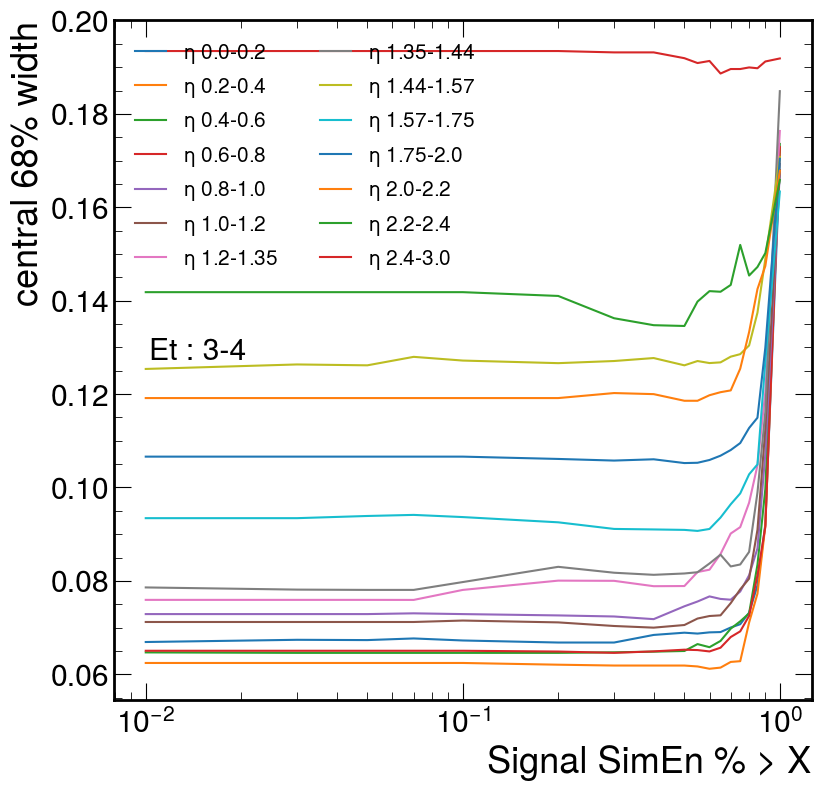

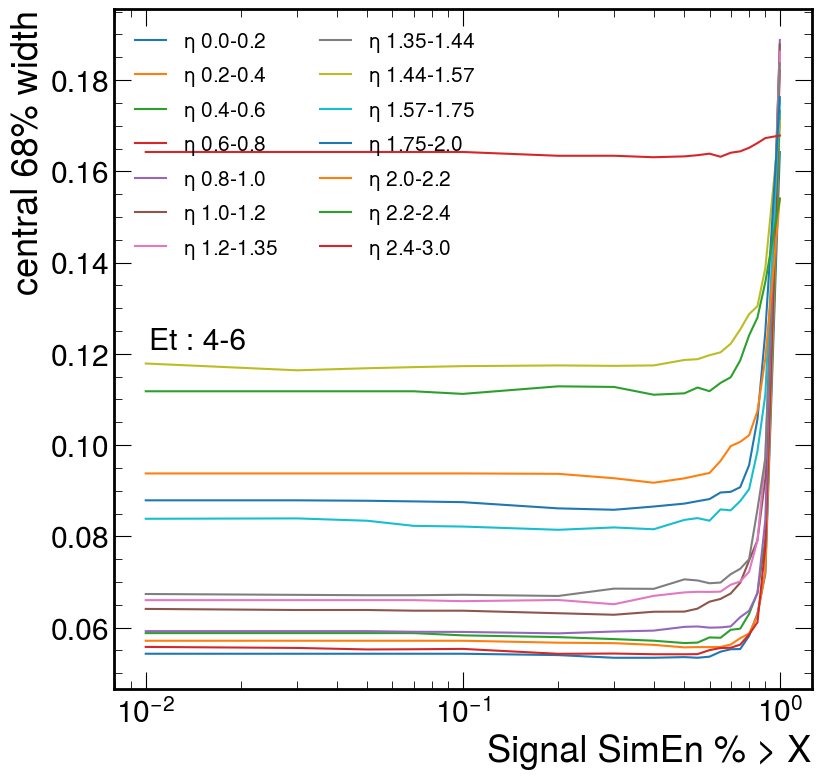

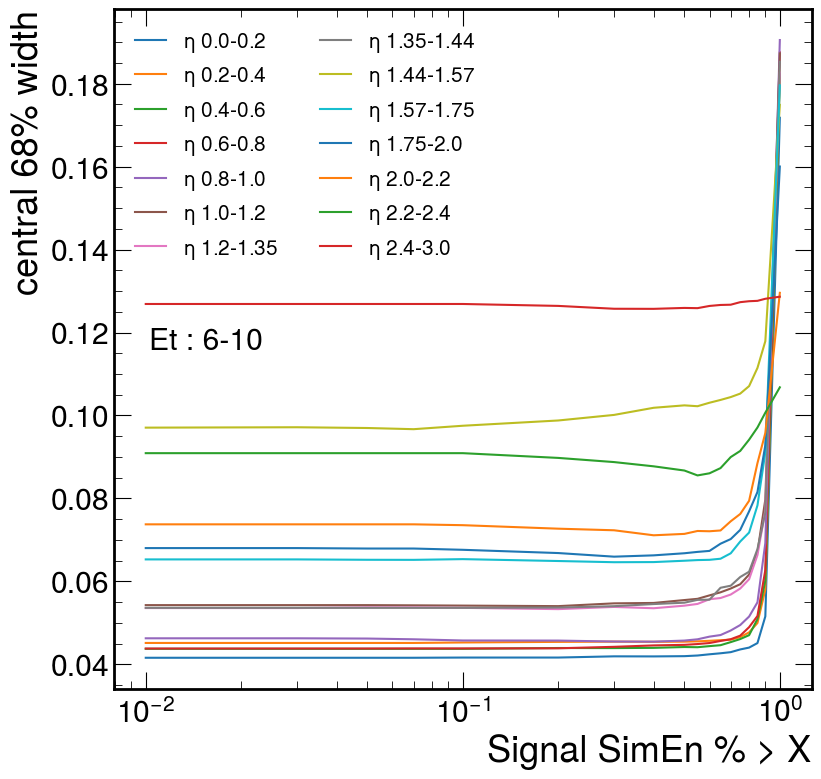

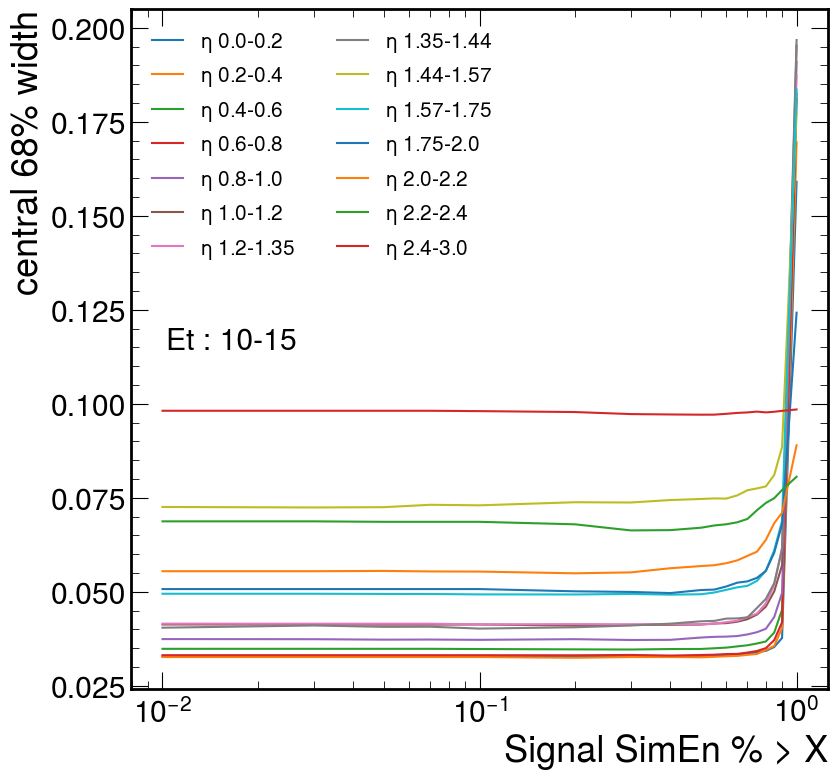

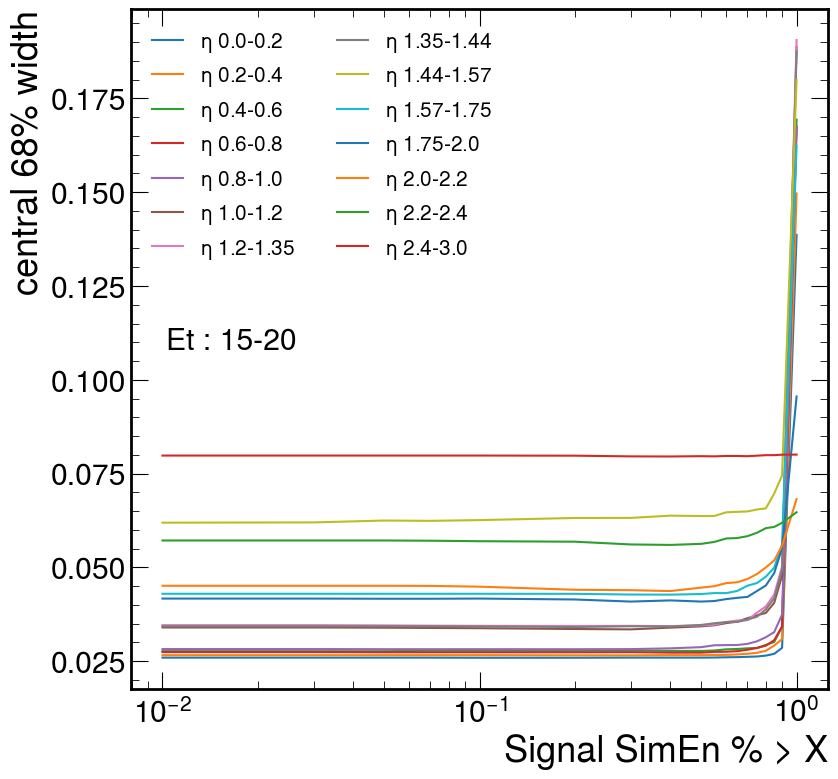

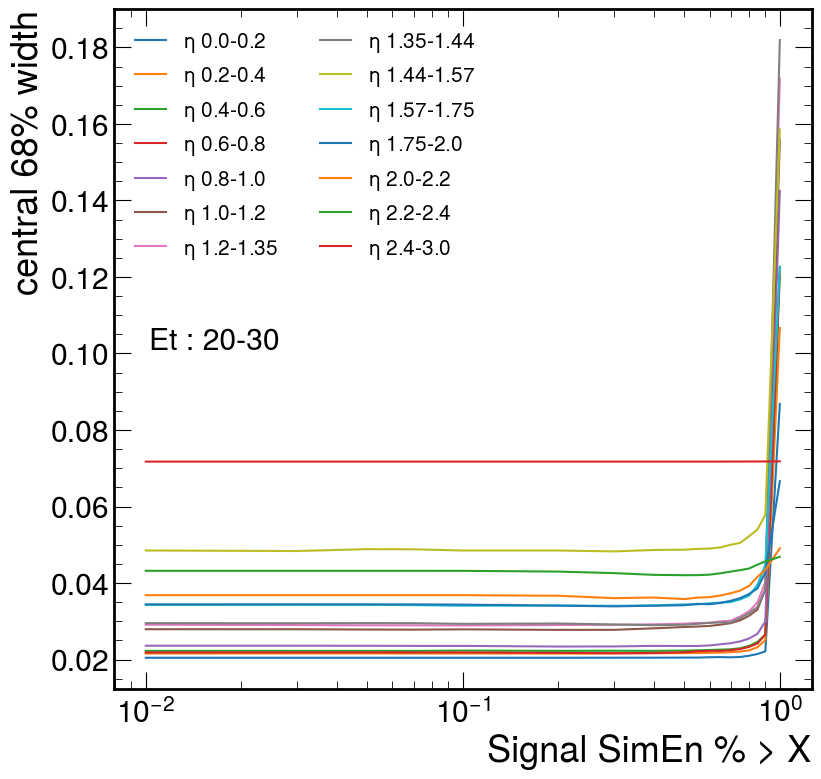

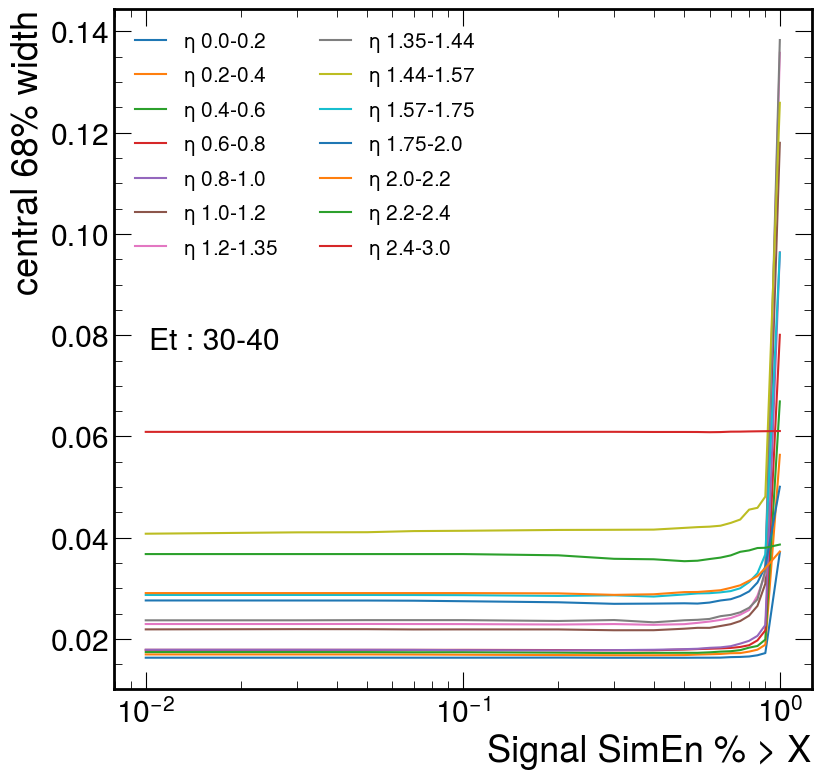

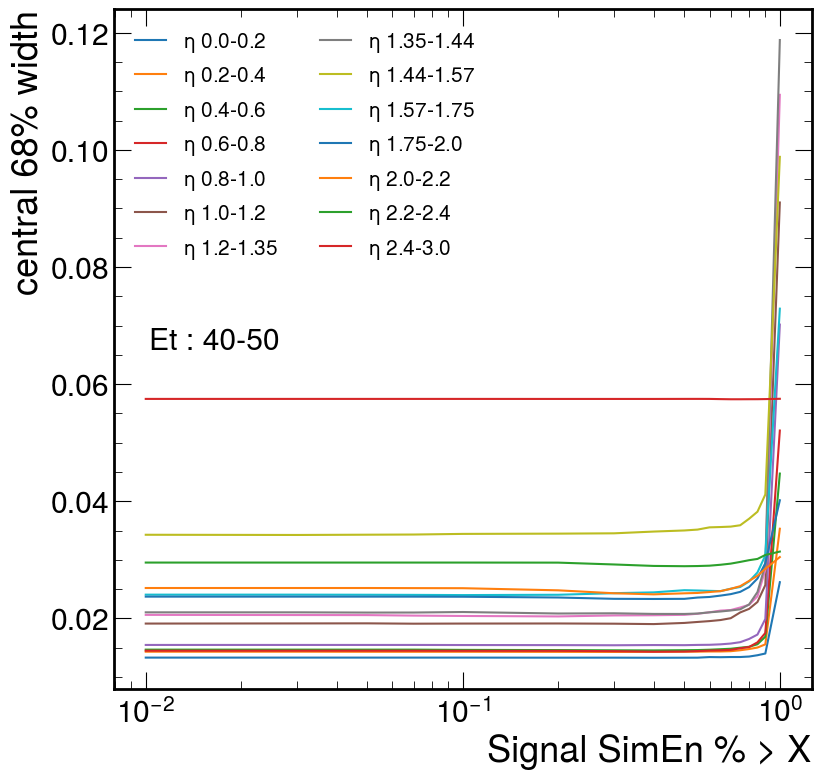

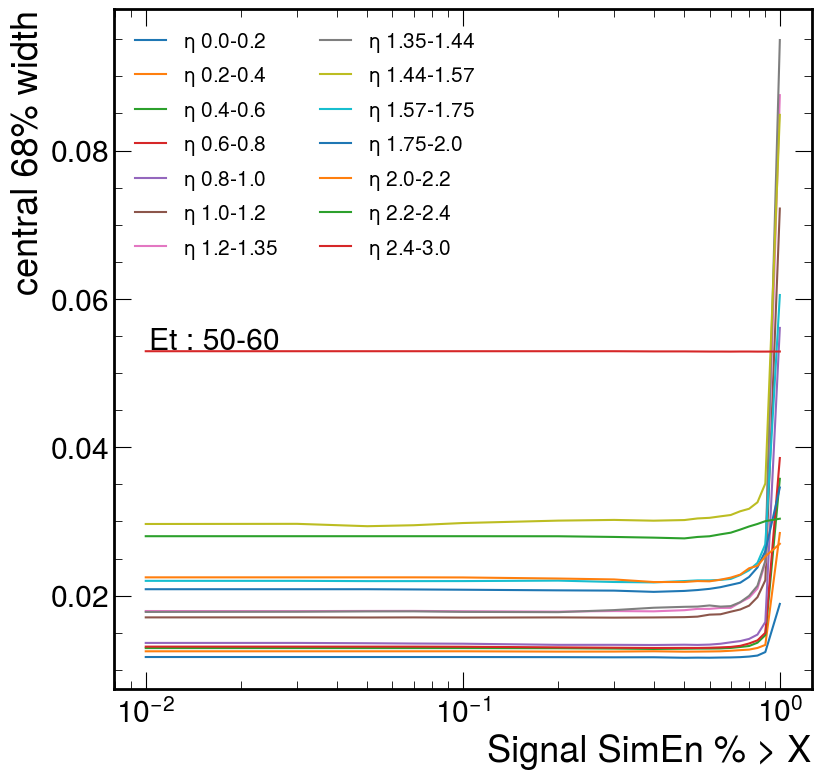

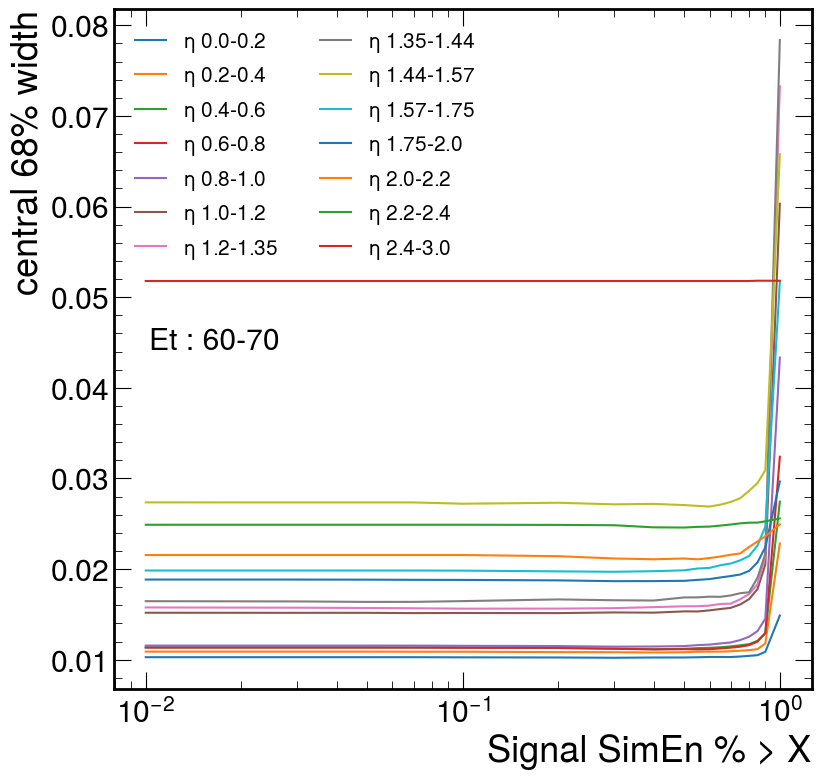

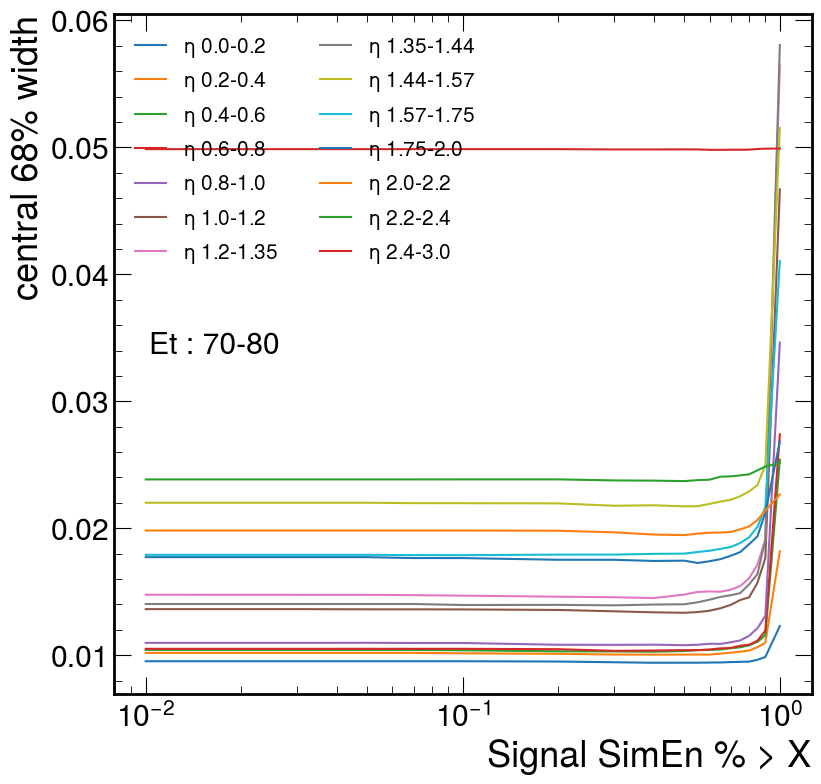

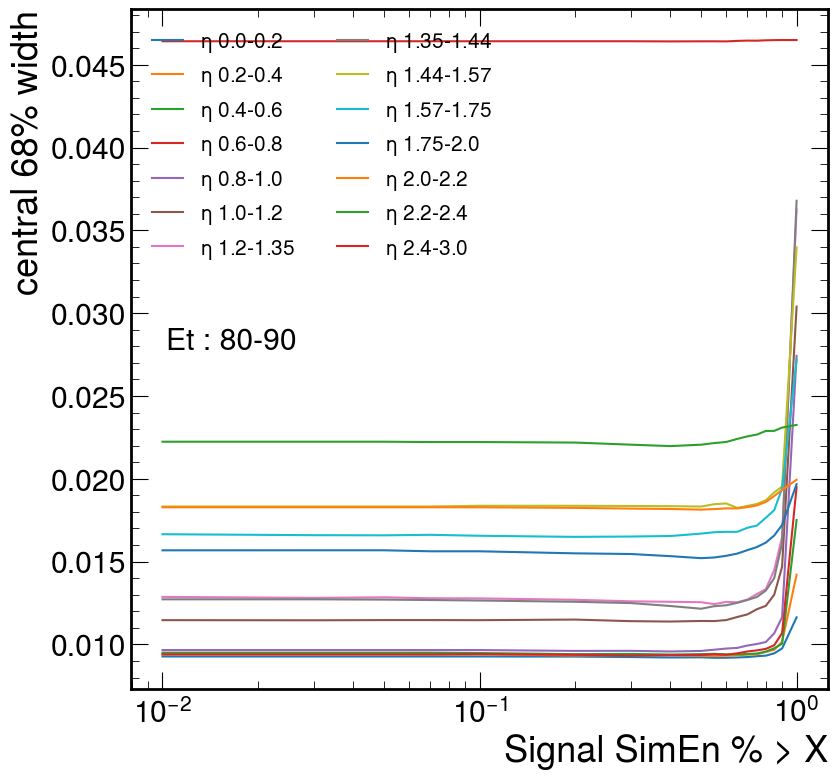

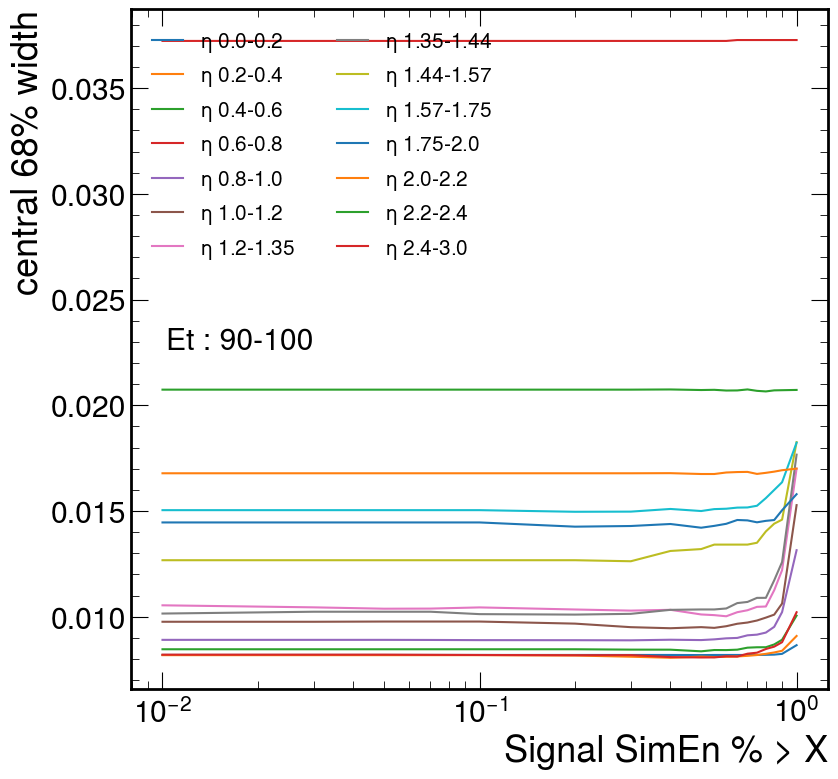

In [41]:
for iet in range(len(ets)-1):
    f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

    for i in range(len(etas)-1): 
        a = res[(res.eta_bin == i) & (res.et_bin==iet)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]))

    ax.text(0.05,0.5, "Et : {}-{}".format(ets[iet],ets[iet+1]),fontsize="small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper left', ncol=2)
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("Signal SimEn % > X")
    #     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

    f.savefig(outputdir+'/Width_Et{}_{}.png'.format(ets[iet],ets[iet+1]))

# Scale

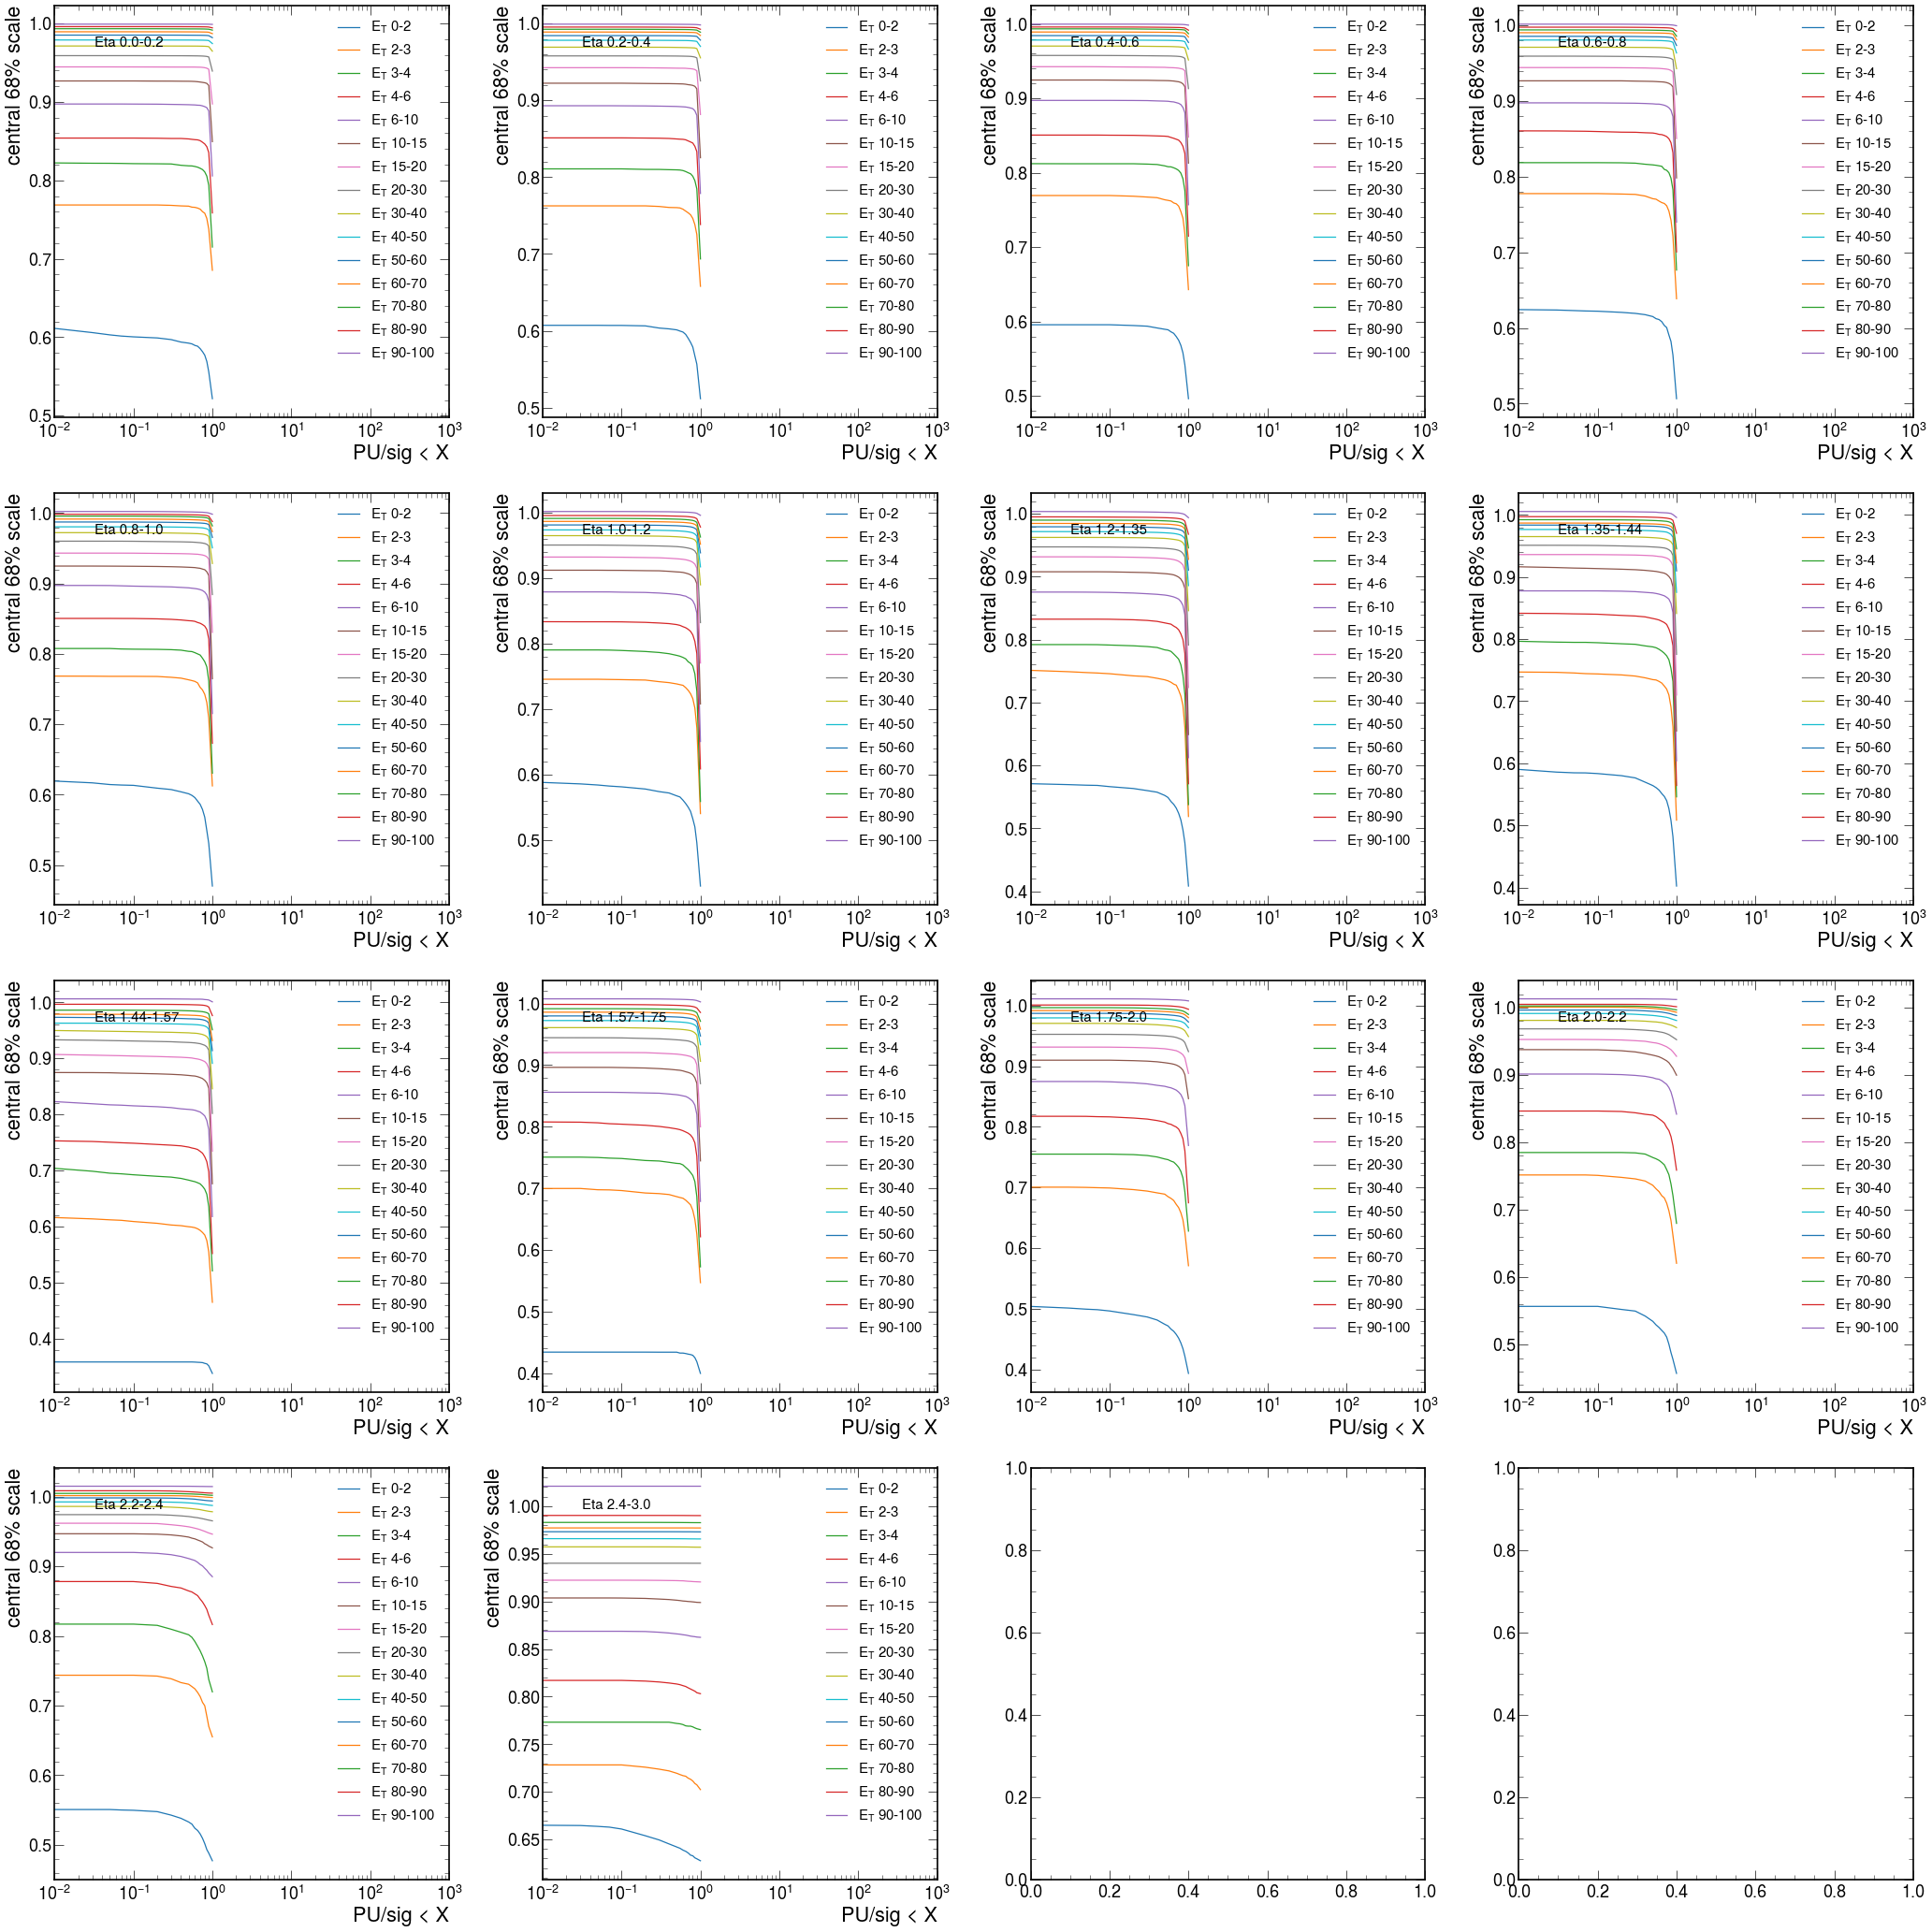

In [37]:
f, axs = plt.subplots(4,4, figsize=(35,35), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(0,len(ets)-1):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68scale, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.1,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="x-small", loc='upper right')
    ax.set_ylabel("central 68% scale")
    ax.set_xlabel("PU/sig < X")
    ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

f.tight_layout()
f.savefig(outputdir + "/scale_by_PU_thre.png")
    

# Summary

In [43]:
def bin_analysis_summary(df):
    line = df.iloc[df["EoEtrue_68width"].argmin()]
    return pd.Series({
        "thr": line['thr'],
        "scale": line["EoEtrue_68width"],
        "width": line["EoEtrue_68width"],
        "rel_err" : line["rel_err"]
    })

a = res.groupby(['et_bin','eta_bin']).apply(bin_analysis_summary)

In [44]:
a.reset_index(level=0, inplace=True)
a.reset_index(level=0, inplace=True)

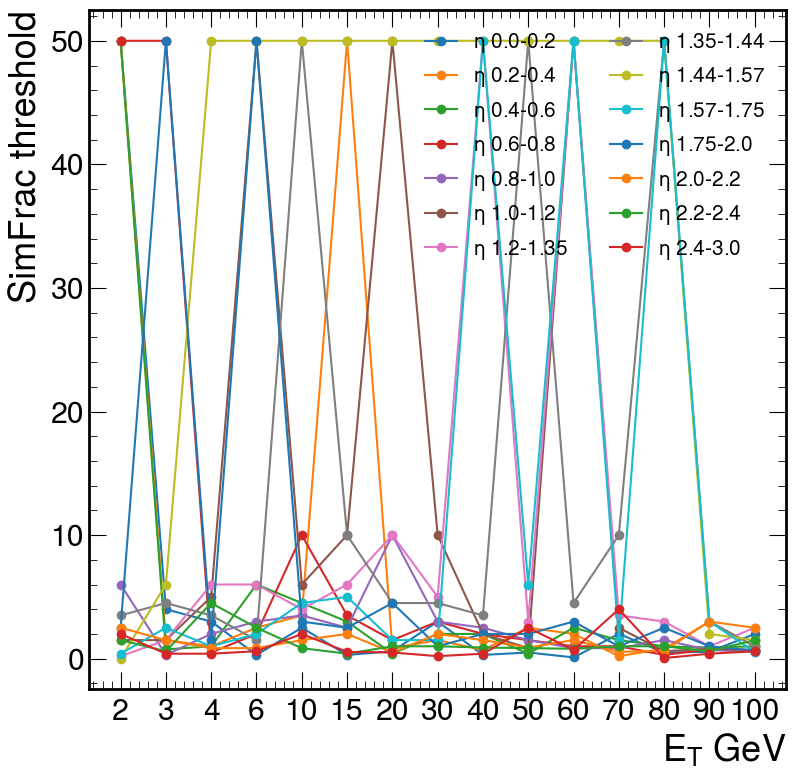

In [45]:
f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

for i in range(len(etas)-1): 
    b = a[a.eta_bin == i]
    ax.plot(b.et_bin, b.thr, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]), marker="o")

ax.legend(fontsize="xx-small", loc='upper right', ncol=2)
ax.set_ylabel("SimFrac threshold")
ax.set_xlabel("$E_T$ GeV")
# ax.set_ylim(1e-4, 10)
# ax.set_yscale("log")
ax.set_xticks(list(range(len(ets)-1)))
ax.set_xticklabels(["{}".format(et) for et in ets[1:]])

f.savefig(outputdir+'/Scale_all.png')

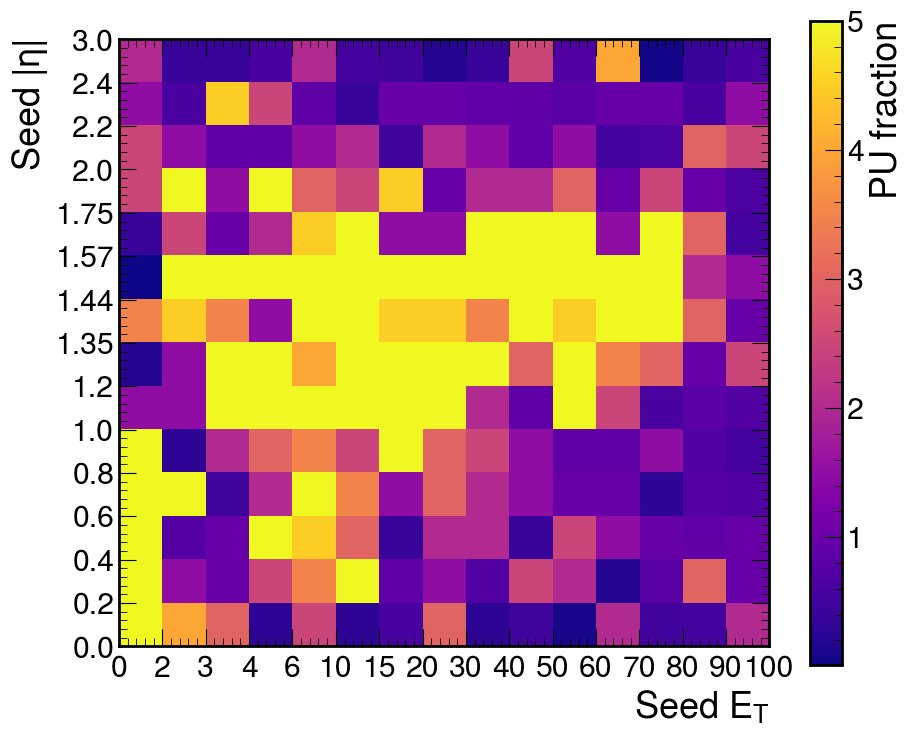

In [46]:
f = plt.figure(figsize=(10,8), dpi=100)
c = a.thr.values.reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", origin="lower", vmax=5)
plt.colorbar(label="PU fraction")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets])
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/PUfraction_map.png")